In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

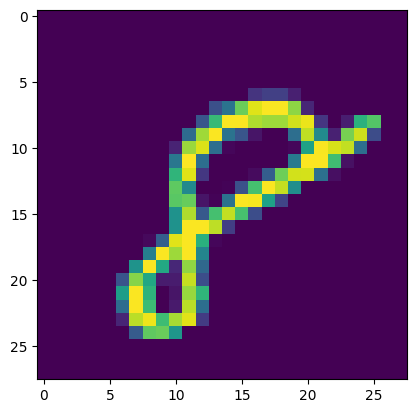

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# let`s train on 0`s and 1`s first
# x_train = x_train[(y_train==0) | (y_train==1)]
# x_test = x_test[(y_test==0) | (y_test==1)]

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

plt.imshow(x_train[-1])

In [3]:
class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = num_clusters
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts] # (batch_size, H, W, C)
        # print("Expert outputs shape:", expert_outputs[0].shape)
        gate_output = self.gate(inputs) # (batch_size, num_experts)
        # print("Gate output shape:", gate_output.shape)
        weighted_expert_outputs = [
            tf.multiply(
                expert_output,
                tf.expand_dims(tf.expand_dims(tf.expand_dims(gate_output[:, i], axis=1), axis=1), axis=1)# (batch_size, 1, 1, 1)
            )
            for i, expert_output in enumerate(expert_outputs)
        ]
        tf.debugging.assert_near(tf.reduce_sum(gate_output, axis=1),
                               tf.ones(tf.shape(gate_output)[0]),
                               message="Gate output should sum to 1")
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """ Conv Autoencoder. """
        # Encoder
        inputs = Input(shape=self.input_dim)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        latent_space = Dense(self.latent_dim, activation="relu")(x)

        # Decoder
        x = Dense(4 * 4 * 32, activation="relu")(latent_space)
        x = Reshape((4, 4, 32))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="valid")(x)
        x = UpSampling2D((2, 2))(x)
        outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

        # Autoencoder
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        x = inputs
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        x = MaxPooling2D((2, 2), padding="same")(x)
        x = Flatten()(x)
        x = Dense(self.num_experts, activation='softmax')(x)
        model = tf.keras.Model(inputs=inputs, outputs=x)
        return model

    def get_expert_outputs(self, x):
        return [expert(x) for expert in self.experts]

    def get_cluster_assignments(self, x):
        gating_weights = self.gate(x)
        return tf.argmax(gating_weights, axis=1)


input_dim = (28,28,1)
num_clusters = 10

model = MixtureOfExperts(input_dim, num_clusters)
model.compile(optimizer='adam', loss='mse')
# model.experts[0].summary()
model.summary()

Model: "mixture_of_experts"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_8 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_9 (Functional)       │ (None, 28, 28, 1)      │        57,611 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 10)             │        25,258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,368 (2.29 MB)

 Trainable params: 601,368 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    x_train, x_train,
    epochs=1,
    batch_size=6,
    validation_data=(x_test, x_test)
)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 459s 43ms/step - loss: 0.0312 - val_loss: 0.0176


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - loss: 0.0176
Test MSE Loss: 0.01756240800023079


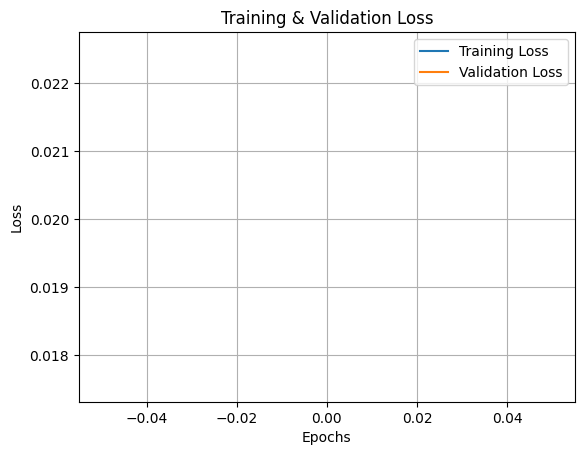

In [5]:
print("Test MSE Loss:", model.evaluate(x_test, x_test))

# Extract loss values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [6]:
x_to_show = x_test[:10]
gating_weights = model.gate(x_to_show)
cluster_assignments = tf.argmax(gating_weights, axis=1)
expert_outputs = model.get_expert_outputs(x_to_show)
expert_outputs[0].shape

TensorShape([10, 28, 28, 1])

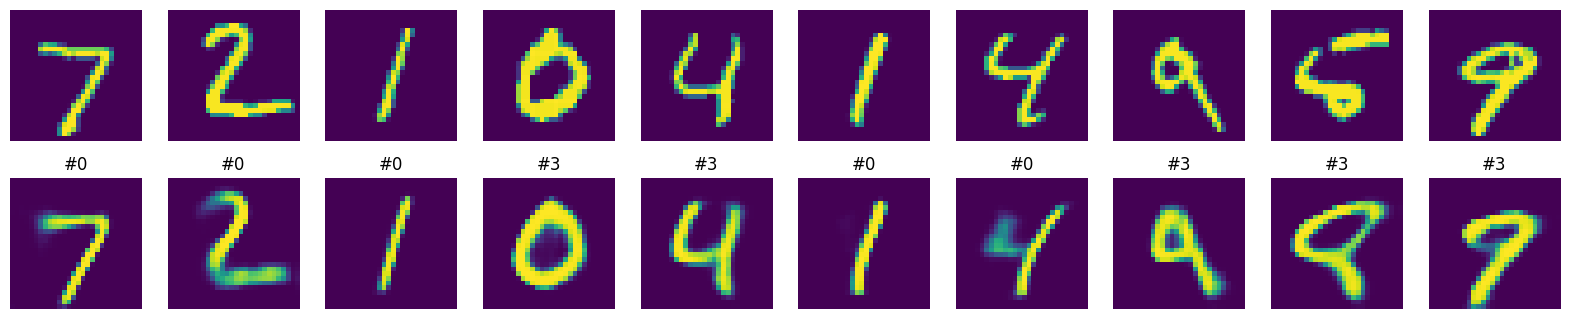

In [7]:
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].squeeze())
    plt.axis('off')

    # Reconstructed image from assigned expert
    plt.subplot(2, 10, i + 11)
    plt.imshow(expert_outputs[cluster_assignments[i]][i].numpy().reshape(28, 28))
    plt.title(f"#{cluster_assignments[i]}")
    plt.axis('off')

plt.show()

In [8]:
model.save("MoA_Conv_Auto_Conv_Gate.keras")